In [13]:
# SecureString parameter stored in AWS System Manager that holds a GitHub personal access token.
parameter_name = 'github_token'

# Repositories for which reports will be generated.
repo_names = ['aws-amplify/amplify-android', 'aws-amplify/aws-sdk-android', 'awslabs/aws-mobile-appsync-sdk-android']

# Labels used across different repositories
issue_buckets = {'Bug': ['Bug'],
                 'Feature Request': ['Improvement', 'Feature Request'],
                 'Question': ['Usage Question'],
                 'Pending Triage': ['Pending Triage']}

# Date Range
start_date = '2020-03-01'
end_date = '2020-04-01'

In [2]:
# Retrieve the GitHub token from SSM to prevent oops-I-pushed-credentials-to-GitHub uh-ohs.

import boto3

ssm = boto3.client('ssm')
response = ssm.get_parameter(Name=parameter_name, WithDecryption=True)
token = response['Parameter']['Value']

In [3]:
# Grab all issues from the GitHub V4 GraphQL API

import requests
import json

headers = {'Authorization': f'Bearer {token}'}

def get_issues(owner, name, *, end_cursor=None):
    query = """
    query($owner: String!, $name: String!, $endCursor: String) {
      repository(owner:$owner, name:$name) {
        issues(first:100, after:$endCursor) {
          nodes {
            number
            title
            createdAt
            closedAt
            reactions {
              totalCount
            }
            comments(first:100) {
              nodes {
                createdAt
                author {
                  login
                }
                reactions {
                  totalCount
                }
              }
            }
            labels(first:3) {
              nodes {
                name
              }
            }
          }
          pageInfo {
            hasNextPage
            endCursor
          }
        }
      }
    }"""
    
    variables = {'owner': owner, 'name': name, 'endCursor': end_cursor}
    response = execute(query, variables)
    page_info = response['data']['repository']['issues']['pageInfo']
    nodes = response['data']['repository']['issues']['nodes']
    
    for issue in nodes:
        yield issue
    
    if page_info['hasNextPage']:
        yield from get_issues(owner, name, end_cursor=page_info['endCursor'])
    
def execute(query, variables):
    request = requests.post('https://api.github.com/graphql', json={'query': query, 'variables': variables},
                                                              headers=headers)

    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("{}: {}".format(request.status_code, query))

In [4]:
# Loop through each repository, grab all issues, and create a DataFrame for each.

import pandas as pd

repos = {}
bucket_lookup = {label: bucket for bucket, labels in issue_buckets.items() for label in labels}

for repo_name in repo_names:
    issues = []
    owner, name = repo_name.split('/')

    for issue in get_issues(owner, name):
        labels = pd.array([label['name'] for label in issue['labels']['nodes']])
        bucket = 'Other'
        created_at = pd.Timestamp(issue['createdAt'],tz='UTC')
        
        score = 1
        score += len(issue['comments']) 
        score += issue['reactions']['totalCount']
        score += sum(comment['reactions']['totalCount'] for comment in issue['comments']['nodes'])
        
        if issue['closedAt']:
            closed_at = pd.Timestamp(issue['closedAt'], tz='UTC')
        else:
            closed_at = None
            
        for label in labels:
            if label in bucket_lookup:
                bucket = label
                break
                
        issues.append([issue['number'], issue['title'], labels, created_at, closed_at, bucket, score])
        
    repos[repo_name] = pd.DataFrame(issues, columns=['id', 'title', 'labels', 'created_at', 'closed_at', 'bucket', 'score'])

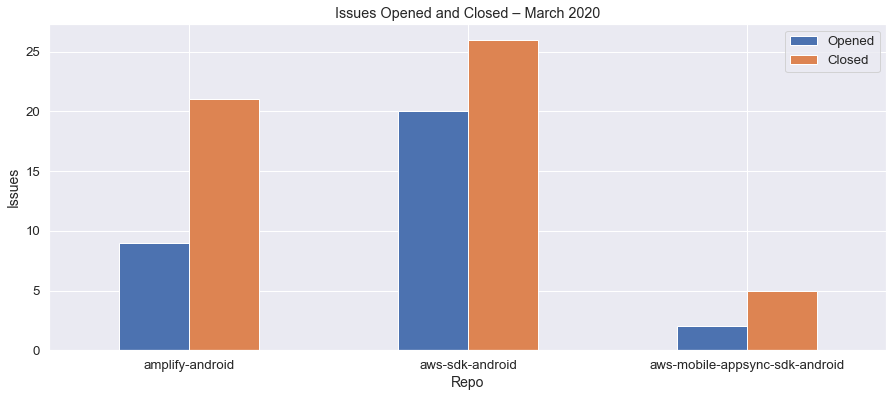

In [99]:
# Issues Opened and Closed by Week

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

%matplotlib inline

opened_and_closed = []

for repo_name, df in repos.items():
    opened = df.loc[(df.created_at > start_date)] 
    opened = opened.loc[(df.created_at < end_date)] 
    closed = df.loc[(df.closed_at > start_date)]
    closed = closed.loc[(df.closed_at < end_date)]

    opened = opened.set_index('created_at')
    closed = closed.dropna().set_index('closed_at')

    repo_name = repo_name[repo_name.index('/')+1:]
    opened_and_closed.append([repo_name, opened['id'].count(), closed['id'].count()])

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})

df = pd.DataFrame(opened_and_closed, columns=['repo_name', 'Opened', 'Closed'])
ax = df.plot(kind='bar', figsize=(15, 6), legend=True)

ax.set_xlabel('Repo', fontsize=14)
ax.set_xticklabels(df['repo_name'], rotation=0)
ax.set_ylabel('Issues', fontsize=14)

ax.set(title=f'Issues Opened and Closed – March 2020')
    
plt.show()

In [46]:
# Top Closed Bugs by Activity

display(HTML(f'<h1>Top Closed Issues by Activity</h1>'))

for repo_name, df in repos.items():
    df = df[(df.closed_at > '2020-03-01')]
    df = df[(df.closed_at < '2020-04-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)

    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'bucket', 'score']].head(10))

,id,title,created_at,bucket,score
24,211,Initialization in Activity#onCreate() may caus...,2020-01-02 21:23:34+00:00,Bug,4
22,209,[DataStore] Freeze on startup,2019-12-30 15:22:51+00:00,Bug,3
33,234,Amplify.API.mutate,2020-01-16 21:23:15+00:00,Other,3
25,212,Lambdafication of Android Category Behaviors,2020-01-02 21:32:45+00:00,Improvement,3
52,319,Amplify import error after 'modelgen' gradle task,2020-03-23 15:14:48+00:00,Bug,3
12,123,[StorageEngine] Re-factor SqlCommand to own va...,2019-11-29 21:25:42+00:00,Other,2
13,143,Add synchronization mechanism in SQLiteStorage...,2019-12-02 19:27:53+00:00,Improvement,2
15,170,[Analytics] Support for identifyUser and autom...,2019-12-04 19:07:41+00:00,Improvement,2
16,171,CircleCI improvements,2019-12-04 19:09:34+00:00,Improvement,2
9,71,[StorageEngine] Support Multi-Auth with the pe...,2019-11-12 18:19:47+00:00,Improvement,2


,id,title,created_at,bucket,score
802,1262,"I get ""No cached session error"" after calling ...",2019-10-19 11:16:44+00:00,Bug,5
846,1393,AWSIotMqttManager.publishString with Callback ...,2019-12-25 13:15:24+00:00,Usage Question,4
890,1500,pause in TransferUtility seems not work,2020-03-03 04:36:46+00:00,Bug,4
889,1499,Issues in Confirm Sign in in less Api 23 in an...,2020-03-02 12:29:11+00:00,Bug,4
884,1488,Enable custom auth flow on demand,2020-02-25 09:06:35+00:00,Usage Question,4
871,1465,GetToken() return java.lang.Exception: getToke...,2020-02-04 14:15:49+00:00,Bug,3
725,1074,Pinpoint is losing events when device is offline,2019-07-18 08:12:01+00:00,Bug,2
887,1496,Faild query in aws android Api 17,2020-03-01 09:32:06+00:00,Other,2
902,1523,"The Cognito error messages are too verbose, es...",2020-02-19 15:12:13+00:00,Bug,2
901,1518,Confirm signIn not working in api less than 23,2020-03-16 14:29:02+00:00,Other,2


,id,title,created_at,bucket,score
131,217,Mutation are not executed in order,2019-10-09 13:45:57+00:00,Other,4
153,264,"After token expired and sign-in again, new tas...",2020-02-27 17:03:21+00:00,Bug,3
136,228,Update to AWS Android SDK v2.16.2,2019-11-12 19:44:09+00:00,Other,2
142,240,AWS App Sync background support,2019-12-03 19:59:01+00:00,Other,2
154,265,java.lang.NullPointerException: Attempt to inv...,2020-03-05 05:45:18+00:00,Other,2


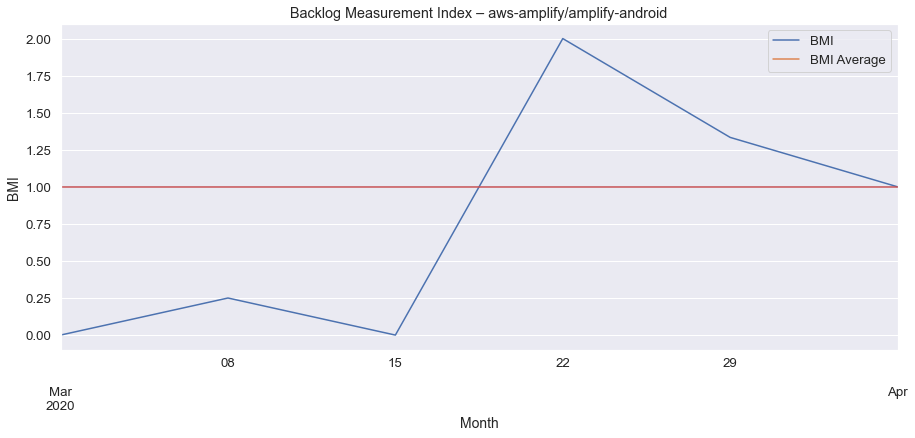

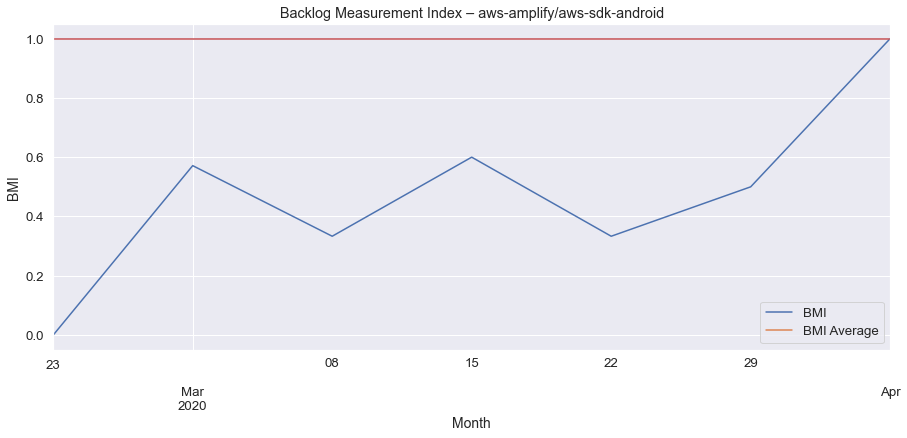

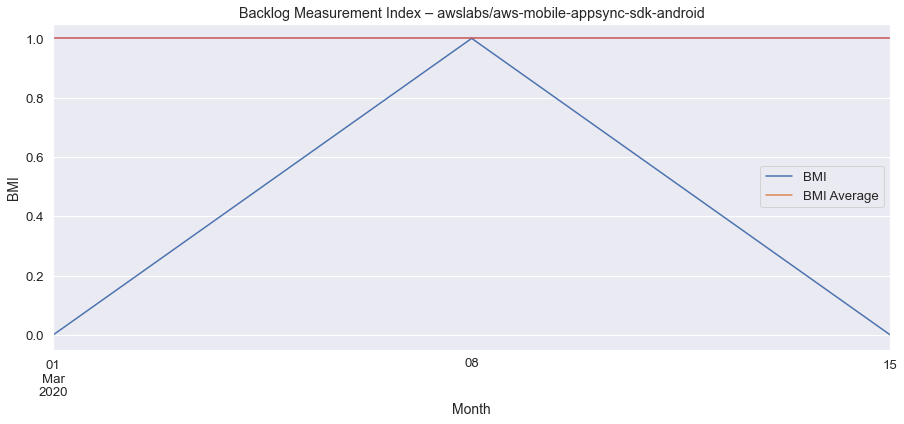

In [52]:
# Backlog Management Index

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

%matplotlib inline


for repo_name, df in repos.items(): 
    df = df.loc[df.created_at > now - timedelta(weeks=6)] 

    opened = df.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = df.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})

    both['Closed'] = both['Closed'].fillna(0)
    both['Opened'] = both['Opened'].fillna(0)
    both['BMI'] = both['Closed'] / both['Opened']
    both['BMI'] = both['BMI'].replace([np.inf, -np.inf], np.nan)
    both['BMI'] = both['BMI'].fillna(both['Closed'])

    both['BMI Average'] = both['BMI'].rolling(window=8).mean()

    ax = both[['BMI', 'BMI Average']].plot(kind='line', figsize=(15, 6), legend=True)
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('BMI', fontsize=14)
    
    ax.set(title=f'Backlog Measurement Index – {repo_name}')
    
    plt.axhline(y=1.0, color='r', linestyle='-')
    plt.show()